In [6]:
import gym, time, torch, os, sys, importlib
import matplotlib.pyplot as plt
import numpy as np

from torch import nn, optim

sys.path.append(os.path.abspath('..')) # Add parent directory to path
import ppo
importlib.reload(ppo) # Prevents caching issues

from ppo import PPONetwork, PPOWrapper
from ppo import parameter_sweeper, pick_parameter_sweep_results, plot_sweep_results

In [7]:
# Initialize the CartPole environment
gym_kwargs = {"id": "CartPole-v1", "render_mode": "rgb_array"}
env = gym.make(**gym_kwargs)

# Define the neural network for the PPO agent
input_dim = 4
output_dim = 2

network_kwargs = {"input_dim": input_dim, "output_dim": output_dim}
network = PPONetwork(**network_kwargs)

# Define the PPO hyperparameters
gamma = 0.99  # Discount factor
lam = 0.90  # Lambda parameter for GAE
clip_epsilon = 0.1  # Controls how much the policy can change
initial_lr = 5e-4  # Initial learning rate
final_lr = 1e-6  # Final learning rate
value_coef = 0.5  # Weight for value loss
entropy_coef = 0.05  # Weight for entropy bonus
batch_epochs = 10  # Number of update epochs per batch
batch_size = 64  # Size of mini-batches
batch_shuffle = True # Shuffle the training data
checkpointing = False # Revert to previous model if new model is worse

anneal_clip = False
anneal_entropy = False
anneal_lambda = False

# Create the PPO agent
ppo_kwargs = {"gamma": gamma, "lam": lam, "clip_epsilon": clip_epsilon, "initial_lr": initial_lr, "final_lr": final_lr, "value_coef": value_coef, "entropy_coef": entropy_coef, "batch_size": batch_size, "batch_epochs": batch_epochs, "batch_shuffle": batch_shuffle, "checkpointing": checkpointing, "anneal_clip": anneal_clip, "anneal_entropy": anneal_entropy, "anneal_lambda": anneal_lambda}
ppo = PPOWrapper(env, network, **ppo_kwargs)

# Make sure it runs
_ = ppo.train_model(1, display=True)

Episode: 0	 avg life: 22.80, eval reward: 74.20, eval ma: 7.42


[74.2]

In [ ]:
# Parameter sweep
threads = 30
episodes = 150

params_and_values = []

parameter_name = "entropy_coef"
parameter_values = [0.01, 0.1, 0.25, 0.5, 1.0]
params_and_values.append((parameter_name, parameter_values))

parameter_name = "lam"
parameter_values = [0.8, 0.85, 0.9, 0.95, 0.99]
params_and_values.append((parameter_name, parameter_values))

parameter_name = "value_coef"
parameter_values = [0.1, 0.25, 0.5, 0.75, 1.0]
params_and_values.append((parameter_name, parameter_values))

parameter_name = "clip_epsilon"
parameter_values = [0.05, 0.1, 0.15, 0.2, 0.25]
params_and_values.append((parameter_name, parameter_values))

parameter_name = "batch_size"
parameter_values = [32, 64, 128, 256, 512]
params_and_values.append((parameter_name, parameter_values))

parameter_name = "batch_epochs"
parameter_values = [5, 10, 15, 20, 25]
params_and_values.append((parameter_name, parameter_values))

params_and_values2 = []

parameter_name = "batch_shuffle"
parameter_values = [True, False]
params_and_values2.append((parameter_name, parameter_values))

params_and_values3 = []
parameter_name = "anneal_clip"
parameter_values = [True, False]
params_and_values3.append((parameter_name, parameter_values))

parameter_name = "anneal_entropy"
parameter_values = [True, False]
params_and_values3.append((parameter_name, parameter_values))

parameter_name = "anneal_lambda"
parameter_values = [True, False]
params_and_values3.append((parameter_name, parameter_values))

folder = "param_sweeps"
files = [f for f in os.listdir(folder) if f.endswith(".json")]
for f in files:
    param, value = pick_parameter_sweep_results(f"{folder}/{f}")
    ppo_kwargs[param] = value
    
p = None
vs = None
sweep_file = parameter_sweeper(episodes, threads, p, vs, gym_kwargs, network_kwargs, ppo_kwargs, custom_name="best_params")

# Run the parameter sweep
for p, vs in params_and_values3:
    break
    sweep_file = parameter_sweeper(episodes, threads, p, vs, gym_kwargs, network_kwargs, ppo_kwargs)

Best value for parameter batch_shuffle: true
Best value for parameter best_params: 0
Best value for parameter batch_size: 32
Best value for parameter entropy_coef: 0.25
Best value for parameter anneal_lambda: false
Best value for parameter value_coef: 0.75
Best value for parameter anneal_entropy: false
Best value for parameter clip_epsilon: 0.05
Best value for parameter batch_epochs: 25
Best value for parameter anneal_clip: true
Best value for parameter lam: 0.9
Starting parameter: best_params, values: [0]
	Running value: 0


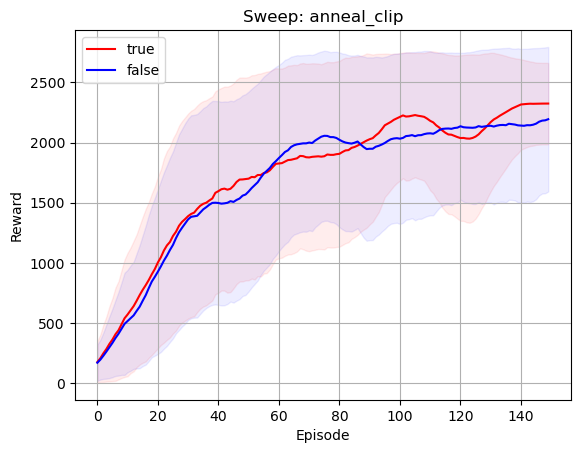

Best value for parameter anneal_clip: true
Best anneal_clip: true


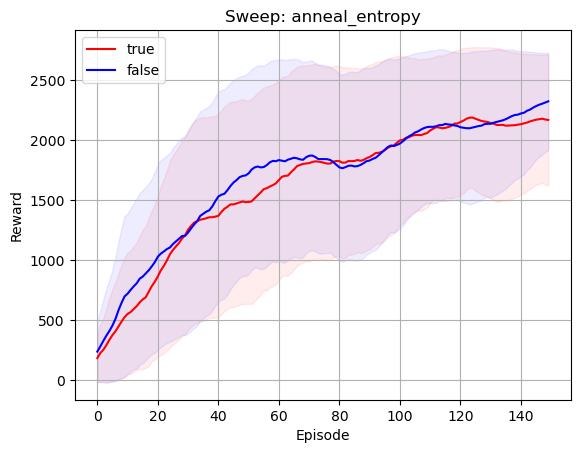

Best value for parameter anneal_entropy: false
Best anneal_entropy: false


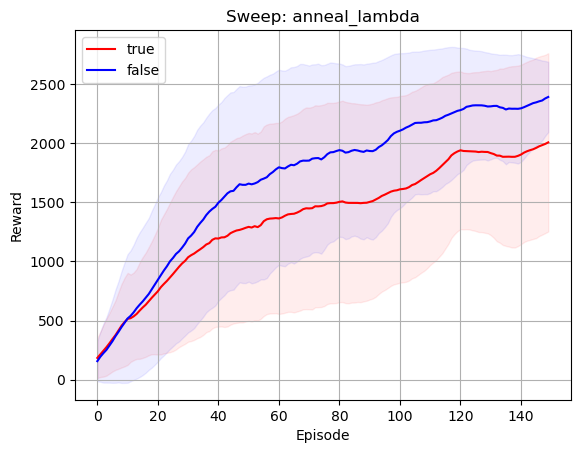

Best value for parameter anneal_lambda: false
Best anneal_lambda: false


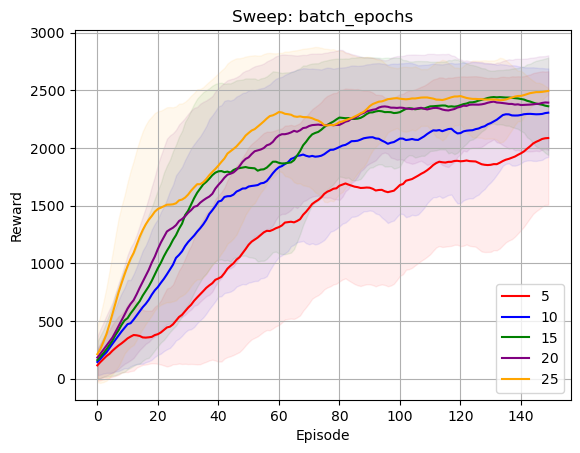

Best value for parameter batch_epochs: 25
Best batch_epochs: 25


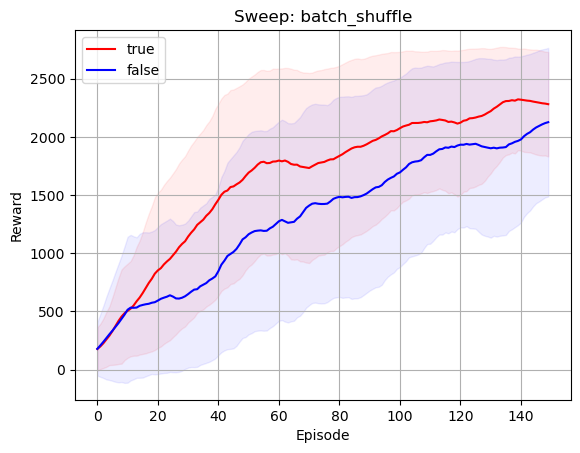

Best value for parameter batch_shuffle: true
Best batch_shuffle: true


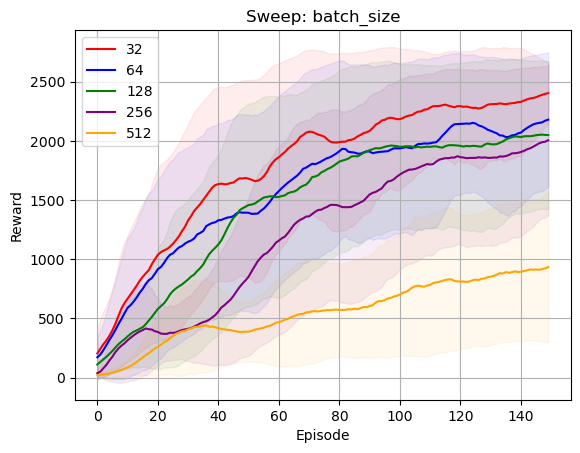

Best value for parameter batch_size: 32
Best batch_size: 32


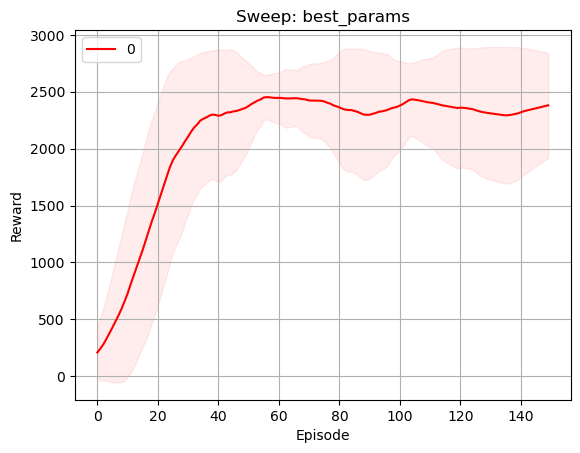

Best value for parameter best_params: 0
Best best_params: 0


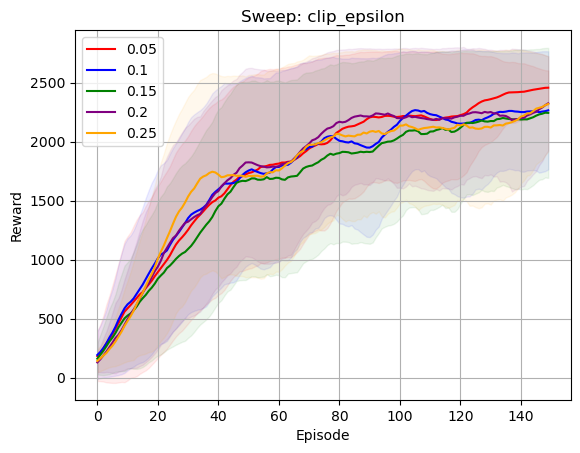

Best value for parameter clip_epsilon: 0.05
Best clip_epsilon: 0.05


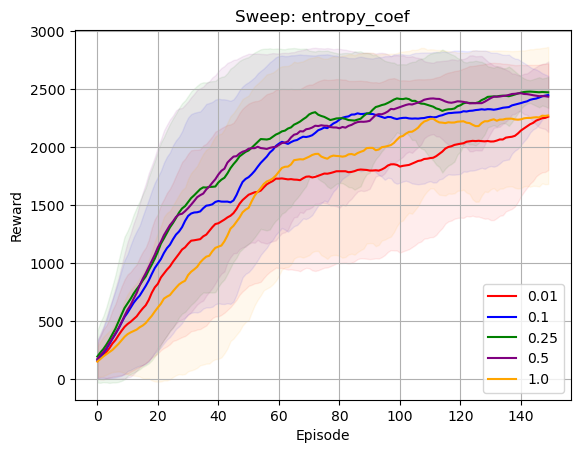

Best value for parameter entropy_coef: 0.25
Best entropy_coef: 0.25


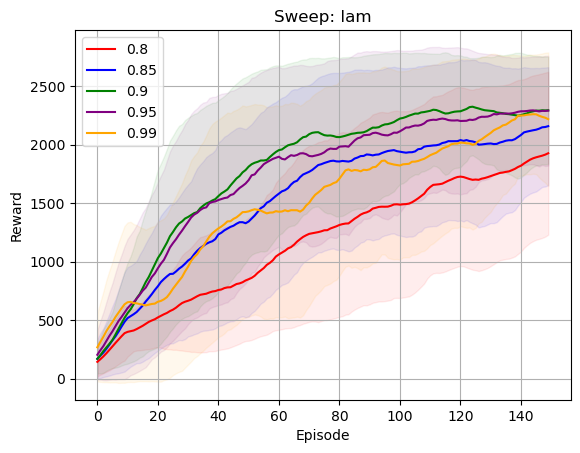

Best value for parameter lam: 0.9
Best lam: 0.9


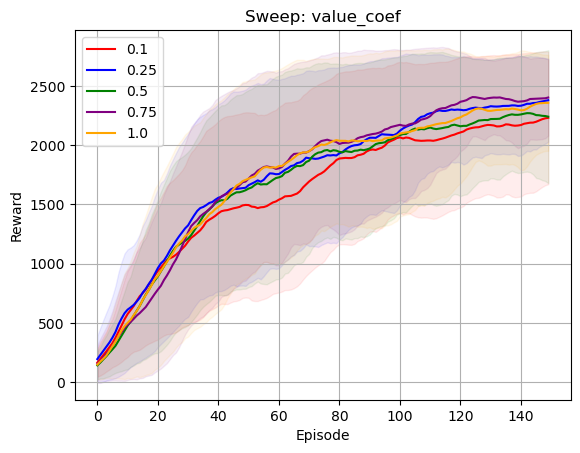

Best value for parameter value_coef: 0.75
Best value_coef: 0.75


In [4]:
# Plot all sweeps
folder = "param_sweeps"
files = [f for f in os.listdir(folder) if f.endswith(".json")]
# Sort alphabetically
files.sort()
for f in files:
    plot_sweep_results(f"{folder}/{f}", moving_average=15)
    param, value = pick_parameter_sweep_results(f"{folder}/{f}")
    print(f"Best {param}: {value}")

In [5]:

# 15.9 sec for 5 episodes, 1 thread
# 37.9 sec for 5 episodes, 10 threads
# Speedup = 4.20x

# 37.5 sec for 10 episodes, 1 thread
# 84.2 sec for 10 episodes, 10 threads
# Speedup = 4.45x

# 1 thread, 5 episodes, 2 parameters
# ThreadpoolExecutor, as_completed: 4.5s
# ProcessPoolExecutor, as_completed: 6.9s

# 3 threads, 5 episodes, 2 parameters
# ThreadpoolExecutor, for future: 21.9s
# ThreadpoolExecutor, as_completed: 20.5s
# ProcessPoolExecutor, for future: 9s
# ProcessPoolExecutor, as_completed: 8.5s

# 10 threads, 5 episodes, 2 parameters
# ThreadpoolExecutor, as_completed: 190.0s
# ProcessPoolExecutor, as_completed: 16.6s

# 30 threads, 5 episodes, 2 parameters
# ProcessPoolExecutor, as_completed: 39.2s

# 30 threads, 10 episodes, 5 parameters
# ProcessPoolExecutor, as_completed: 213.1s

# 30 threads, 100 episodes, 3 parameters
# ProcessPoolExecutor, as_completed: 38 min 25 sec
